# Titanic Survival Prediction
_Crystal Xu_
_____


The project aims to predict if the passenger survived or not. <br>
The dataset includes: 
- Personal information like their name, sex and age
- Whether they have relatives aboard together
- Passengers' ticket class and fare and cabin
- The port passengers embarked 

This notebook explores the dataset and compares several predictive models.
____

In [179]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import statistics
from statistics import mode
import sklearn.preprocessing as pp
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors, linear_model, svm, tree, ensemble

# 1. Data Cleaning

### Data Import

In [76]:
data = pd.read_csv (r'titanic.csv')

### Drop unnecessary columns

In [77]:
#drop name, ticket and PassengerId columns
data = data.drop(["Name", "Ticket","PassengerId"],axis = 1)
data

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C85,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C123,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,NaN,S,0
887,1,female,19.0,0,0,30.0000,B42,S,1
888,3,female,NaN,1,2,23.4500,NaN,S,0
889,1,male,26.0,0,0,30.0000,C148,C,1


### Fill NA

In [71]:
data.isna().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
Survived      0
dtype: int64

In [78]:

#Age: fill with mean
mean = data['Age'].mean()
data['Age'].fillna(mean, inplace=True)

#Cabin: fill with special letter N 
data['Cabin'].fillna("N", inplace=True)

#Embarked: fill with mode
mode = data['Embarked'].mode()[0]
data['Embarked'].fillna(mode, inplace=True)

data.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Survived    0
dtype: int64

### Clean the data

In [56]:
#take the first letter for cabin
data["Cabin"] = [s[0] for s in data["Cabin"]]
data

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,1,3,male,22.000000,1,0,7.2500,N,S,0
1,2,1,female,38.000000,1,0,71.2833,C,C,1
2,3,3,female,26.000000,0,0,7.9250,N,S,1
3,4,1,female,35.000000,1,0,53.1000,C,S,1
4,5,3,male,35.000000,0,0,8.0500,N,S,0
...,...,...,...,...,...,...,...,...,...,...
886,887,2,male,27.000000,0,0,13.0000,N,S,0
887,888,1,female,19.000000,0,0,30.0000,B,S,1
888,889,3,female,29.699118,1,2,23.4500,N,S,0
889,890,1,male,26.000000,0,0,30.0000,C,C,1


# 2. EDA

## 2.1 Distribution

In [89]:
data.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,0.836071,13.002015,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


Insights: 
- Average age is 30, and 75% quantile of age is 35. Most of passengers are under 35
- Over 50% of passengers do not have Siblings/Spouses abroad
- Only a small amount of passengers have Parents/Children aborad

array([[<AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Survived'}>]], dtype=object)

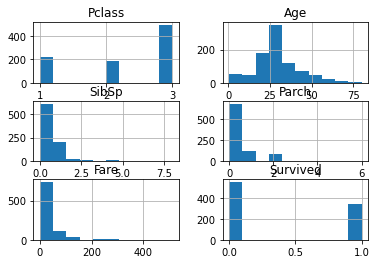

In [88]:
#Show histogram
data.hist()

In [92]:
#find survival rate
survive = data['Survived'].value_counts()[0]
death = data['Survived'].value_counts()[1]
survival_rate = survive/(death+survive)
survival_rate

0.6161616161616161

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

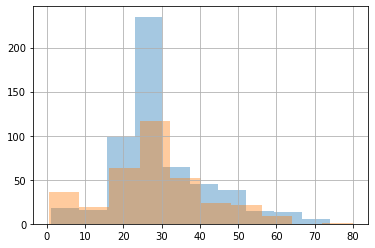

In [106]:
# Compare the age of survived and death group
data.groupby('Survived').Age.hist(alpha=0.4)

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Pclass, dtype: object

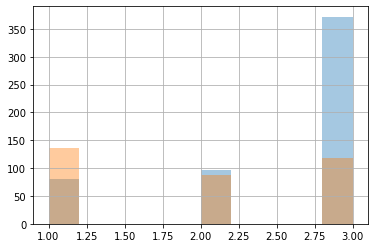

In [107]:
data.groupby('Survived').Pclass.hist(alpha=0.4)

Ingishts: 
- most of passengers in class 3 with lower fare
- survival_rate is about 61.62%
- For Age[0-10], more passengers survived
- For Age[28-30], passengers died a lot more than survived 
- A lot of passengers survived in 1st class and a large portition of passengers died in 3rd class 

## 2.2 Clustering

In [108]:
num_feat = ['Age', 'SibSp','Parch','Fare']
cat_feat = ['Pclass','Sex', 'Cabin','Embarked']
preproc = ColumnTransformer(transformers=[('num', pp.StandardScaler(), num_feat), ('cat', pp.OneHotEncoder(), cat_feat)])
cl_X = data[num_feat + cat_feat]
preproc.fit(cl_X)
cl_features = preproc.transform(cl_X)

### K-Means

In [121]:
# find the right amount of clusters
for n_clusters in range(2,6):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(cl_features)
    clusters = kmeans.predict(cl_features)
    silhouette_avg = silhouette_score(cl_features, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.3856138007435648
For n_clusters = 3 The average silhouette_score is : 0.31543845483426386
For n_clusters = 4 The average silhouette_score is : 0.3094427485169391
For n_clusters = 5 The average silhouette_score is : 0.2794916122373454


When Cluster = 2, the model has the hiest silhouette_score, so I decide to choose 2 cluster

In [116]:
kmeans = KMeans(init='k-means++', n_clusters = 2, n_init=30)
kmeans.fit(cl_features)
predict = kmeans.predict(cl_features)
cl_result = data
cl_result['cluster'] = pd.Series(predict, index=cl_result.index)

Check the amount of passengers in each Cluster and Analize

In [117]:
pd.Series(predict).value_counts()

1    738
0    153
dtype: int64

In [128]:
cl_analyze = cl_result.groupby('cluster').mean()
cl_analyze['Pclass_mode'] = cl_result.groupby('cluster')['Pclass'].agg(pd.Series.mode)
cl_analyze

,Pclass,Age,SibSp,Parch,Fare,Survived,Pclass_mode
cluster,,,,,,,
0,2.339869,18.741411,1.784314,1.797386,65.474837,0.516340,3
1,2.302168,31.970837,0.261518,0.088076,25.306639,0.356369,3


Insights:
- Cluster 0: - Younger and not alone
    - Younger. Average age is about 19
    - With more Siblings and Spouse 
    - With more Parents and Children
    - Expenseive tickets, more people in expenseive class
- Cluster 1: - Older and alone
    - Older. Average age is about 32
    - With less Siblings and Spouse
    - Alost no Parents or Children together
    - Cheaper tivkers, more people in cheaper class

# 3. Model Training

## 3.1 Data Preparation

In [149]:

#Normalize numeric data & encode category data
num_feat = ['Age', 'SibSp','Parch','Fare']
cat_feat = ['Pclass','Sex', 'Cabin','Embarked']
preproc = ColumnTransformer(transformers=[('num', pp.StandardScaler(), num_feat), ('cat', pp.OneHotEncoder(), cat_feat)])

Y = data['Survived']
X = data.drop(['Survived'],axis=1)

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
preproc.fit(X)
X_train_t = preproc.transform(X_train)
X_test_t = preproc.transform(X_test)


## 3.2 Logistic Regression

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       109
           1       0.75      0.73      0.74        70

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



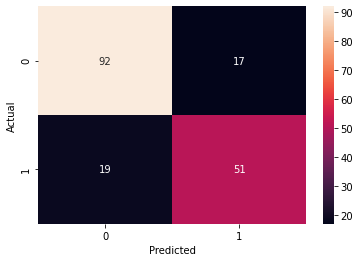

In [189]:
logistic = LogisticRegression()
logistic.fit(X_train_t, y_train)

y_pred_LR = logistic.predict(X_test_t)

print(classification_report(y_test, y_pred_LR))
confusion_matrix_LR = pd.crosstab(y_test, y_pred_LR, rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix_LR, annot=True)
plt.show()

**Conclusion**
- The Accuracy is 0.8, not bad 
- The precision and recall for negative case is higher

## 3.3 Decision Tree

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       109
           1       0.76      0.74      0.75        70

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



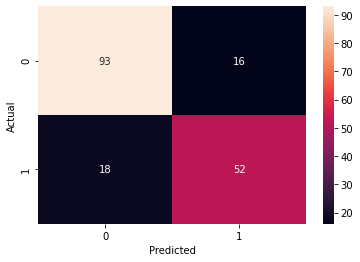

In [210]:
Decision_tree = DecisionTreeClassifier(criterion = 'entropy', splitter="best")
Decision_tree.fit(X_train_t, y_train)

y_pred_DT = Decision_tree.predict(X_test_t)

print(classification_report(y_test, y_pred_DT))
confusion_matrix_DT = pd.crosstab(y_test, y_pred_DT, rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix_DT, annot=True)
plt.show()

**Conclusion**
- Comparing to Logistic Regression model
    - Accuracy is 0.01 higher
    - Precision and recall are also higher


## 3.4 Random Forest

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       109
           1       0.78      0.71      0.75        70

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



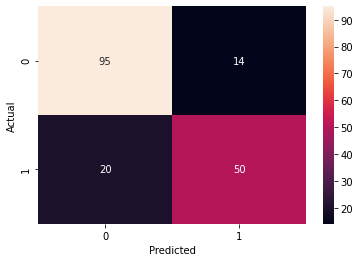

In [152]:
#try with default
rfc = RandomForestClassifier()
rfc.fit(X_train_t, y_train)
y_pred_RF = rfc.predict(X_test_t)
print(classification_report(y_test, y_pred_RF ))
confusion_matrix_RF = pd.crosstab(y_test, y_pred_RF , rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_RF, annot=True)
plt.show()

In [216]:
# Tuning the hyper-parameters

param_grid = {
    'max_depth': [10,20,50,100], 
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
gscv_rfc = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', cv=5)
gscv_rfc.fit(X_train_t, y_train)
gscv_rfc.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [215]:
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 30, 50, 100],
               'max_features' :['sqrt', 'log2']}
gscv_rfc = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', cv=5)
gscv_rfc.fit(X_train_t, y_train)
gscv_rfc.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 30}

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       109
           1       0.84      0.73      0.78        70

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



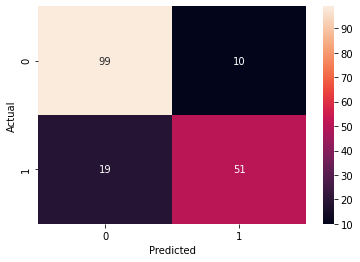

In [230]:
rfc = RandomForestClassifier(max_depth = 20, min_samples_leaf = 1, \
                             min_samples_split = 5, criterion = 'gini', max_features = 'log2', n_estimators = 30)
rfc.fit(X_train_t, y_train)
y_pred_RF = rfc.predict(X_test_t)
print(classification_report(y_test, y_pred_RF ))
confusion_matrix_RF = pd.crosstab(y_test, y_pred_RF , rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_RF, annot=True)
plt.show()

**Conclusioin**
- After Tuning the parameters, all of precision, recall and accuracy score got higher 
- Comparing to Decision Tree and Logistic Regression, all of three scores are higher, the overall accuracy is much better

## 4.5 KNN

In [201]:
param_grid = {'n_neighbors': np.arange(1,50,1)}
gscv_rfc = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, scoring='accuracy', cv=5)
gscv_rfc.fit(X_train_t, y_train)
gscv_rfc.best_params_

{'n_neighbors': 16}

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       109
           1       0.84      0.67      0.75        70

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



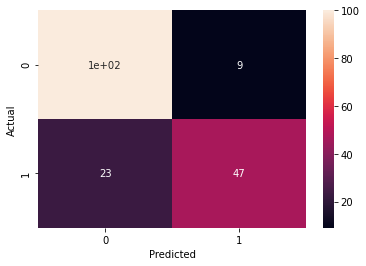

In [198]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 16)
knn.fit(X_train_t, y_train)
y_pred_KNN = knn.predict(X_test_t)
print(classification_report(y_test, y_pred_KNN))
confusion_matrix_KNN = pd.crosstab(y_test, y_pred_KNN, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_KNN, annot=True)
plt.show()

**Conclusion**
- The Accuracy is good 
- The Precision and Recall is higher than Logistic Regression and Decision Tree


# 4. Conclusion

## 4.1 Model Comparing

In [231]:
# Since both the positive and negative cases are important, I choose to compare weighted average of metrics
result = pd.DataFrame(columns=('Model Type', 'Accuracy','Precision','Recall','F1_score'))
result.loc[0]= ["Logistic Regression", accuracy_score(y_test, y_pred_LR), precision_score(y_test, y_pred_LR),recall_score(y_test, y_pred_LR),f1_score(y_test, y_pred_LR)]
result.loc[1]= ["Decision Tree", accuracy_score(y_test, y_pred_DT), precision_score(y_test, y_pred_DT),recall_score(y_test, y_pred_DT),f1_score(y_test, y_pred_DT)]
result.loc[2]= ["Random Forest", accuracy_score(y_test, y_pred_RF), precision_score(y_test, y_pred_RF),recall_score(y_test, y_pred_RF),f1_score(y_test, y_pred_RF)]
result.loc[3]= ["Nearest Neighbors", accuracy_score(y_test, y_pred_KNN), precision_score(y_test, y_pred_KNN),recall_score(y_test, y_pred_KNN),f1_score(y_test, y_pred_KNN)]
result

,Model Type,Accuracy,Precision,Recall,F1_score
0,Logistic Regression,0.798883,0.750000,0.728571,0.739130
1,Decision Tree,0.810056,0.764706,0.742857,0.753623
2,Random Forest,0.837989,0.836066,0.728571,0.778626
3,Nearest Neighbors,0.821229,0.839286,0.671429,0.746032


**Conclusion**  <br>
I would choose _Random Forest_ model. <br>
<br>
I think the Precision is more impoartant than Recall in this case, so I would choose between Random Forest and Nearest Neighbors. </br>
With almost the same precision score, Random Forest is better ar Accuracy, Recall and F1_score. So I would choose Random Forest.


## 4.2 Approach of Deployment

- Data Storage: Since the dataset is small, csv should be a good way to store it 
- Training: The data is one off data, we will not have new data. So we can choose to train one time and store the trained model 
- Tool: The traning and fitting can be done on Python
- Deployment: We can use python Flask to deploy the model and make it a Web App 